In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import scipy

import clmm
from clmm import Cosmology
from clmm import GalaxyCluster
from clmm.dataops import compute_galaxy_weights
from clmm.support import mock_data as mock
clmm.__version__

'1.0.9'

In [2]:
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

In [3]:
cluster_z = 0.4

In [4]:
noisy_data_z = mock.generate_galaxy_catalog(1e14, cluster_z, 4, 
                                                cosmo, 
                                                zsrc = 'chang13', 
                                                delta_so=200, 
                                                massdef='critical',
                                                halo_profile_model='nfw', 
                                                zsrc_min=0.,
                                                zsrc_max=3., 
                                                field_size=10., 
                                                shapenoise=0.5, 
                                                photoz_sigma_unscaled=0.05,
                                                mean_e_err=.1,
                                                ngals=10000)
z_gal = noisy_data_z['ztrue']
z_gal_photoz = noisy_data_z['pzbins']
photoz_pdf_gal = noisy_data_z['pzpdf']
#add redshift dependency on shape measurement error
noisy_data_z['e_err'] = noisy_data_z['e_err']*(1 + 0.4*noisy_data_z['z'])
cl = clmm.GalaxyCluster('mock_cluster', 0, 0, .4, noisy_data_z)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)
/pbs/throng/lsst/users/cpayerne/CLMM/clmm/theory/func_layer.py:416: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
  'Some source redshifts are lower than the cluster redshift.'


### WL weights

as a function

In [5]:
w_ls_true = compute_galaxy_weights(
    cluster_z, cosmo,z_source = z_gal, 
    shape_component1 = noisy_data_z['e1'], shape_component2 = noisy_data_z['e2'], 
    shape_component1_err = noisy_data_z['e_err'],
    shape_component2_err = noisy_data_z['e_err'], 
    pzpdf = None, pzbins = None,
    use_shape_noise = False, is_deltasigma = False)

as a `class` function of the GalaxyCluster object

#### (true redshift + no shape error)

$$
w_{\rm ls} = \Sigma_{\rm crit}(z_l, z_s)^{-2}
$$

In [6]:
w_ls_true = cl.compute_galaxy_weights(
    z_source='ztrue', pzpdf='pzpdf', pzbins='pzbins', 
    shape_component1 = 'e1', shape_component2 = 'e2', 
    shape_component1_err = 'e_err', shape_component2_err = 'e_err', 
    use_photoz = False, use_shape_noise = False, use_shape_error = False, 
    weight_name = 'w_ls_true', p_background_name = 'p_background_true',
    cosmo = cosmo, is_deltasigma = True, add = True)

(re)computing p_background_true


#### (photoz + no shape errors)

$$
w_{\rm ls} = \left(\int_{z_l}^{+\infty}\Sigma_{\rm crit}(z_l, z)^{-1}p(z) dz\right)^2
$$

In [7]:
w_ls_photoz = cl.compute_galaxy_weights(
    z_source='ztrue', pzpdf='pzpdf', pzbins='pzbins', 
    shape_component1 = 'e1', shape_component2 = 'e2', 
    shape_component1_err = 'e_err', shape_component2_err = 'e_err', 
    use_photoz = True, use_shape_noise = False, use_shape_error = False, 
    weight_name = 'w_ls_photoz', p_background_name = 'p_background_photoz',
    cosmo = cosmo, is_deltasigma = True, add = True)

(re)computing p_background_photoz


#### (true redshift + shape error)

$$
w_{\rm ls} = \frac{\Sigma_{\rm crit}(z_l, z_s)^{-2}}{\sigma_{\rm shapenoise}^2 + \sigma^2_{\rm shape\ error}}
$$

In [8]:
w_ls_shape = cl.compute_galaxy_weights(
    z_source='ztrue', pzpdf='pzpdf', pzbins='pzbins', 
    shape_component1 = 'e1', shape_component2 = 'e2', 
    shape_component1_err = 'e_err', shape_component2_err = 'e_err', 
    use_photoz = False, use_shape_noise = True, use_shape_error = True, 
    weight_name = 'w_ls_shape', p_background_name = 'p_background_shape',
    cosmo = cosmo,
    is_deltasigma = True, add = True)

(re)computing p_background_shape


#### (true redshift + shape error)

$$
w_{\rm ls} = \frac{\left(\int_{z_l}^{+\infty}\Sigma_{\rm crit}(z_l, z)^{-1}p(z) dz\right)^2}{\sigma_{\rm shapenoise}^2 + \sigma^2_{\rm shape\ error}}
$$

In [9]:
w_ls_photoz_shape = cl.compute_galaxy_weights(
    z_source='ztrue', pzpdf='pzpdf', pzbins='pzbins', 
    shape_component1 = 'e1', shape_component2 = 'e2', 
    shape_component1_err = 'e_err', shape_component2_err = 'e_err', 
    use_photoz = True, use_shape_noise = True, use_shape_error = True, 
    weight_name = 'w_ls_photoz_shape', p_background_name = 'p_background_photoz_shape',
    cosmo = cosmo,
    is_deltasigma = True, add = True)

(re)computing p_background_photoz_shape


The above methods add the new columns in the `cl.galcat` Table with weights and background probabilities per galaxy in each 

In [10]:
print(cl.galcat.colnames)

['ra', 'dec', 'e1', 'e2', 'e_err', 'z', 'ztrue', 'pzbins', 'pzpdf', 'id', 'p_background_true', 'w_ls_true', 'p_background_photoz', 'w_ls_photoz', 'p_background_shape', 'w_ls_shape', 'p_background_photoz_shape', 'w_ls_photoz_shape']


Text(0.5, 0, 'true redshift')

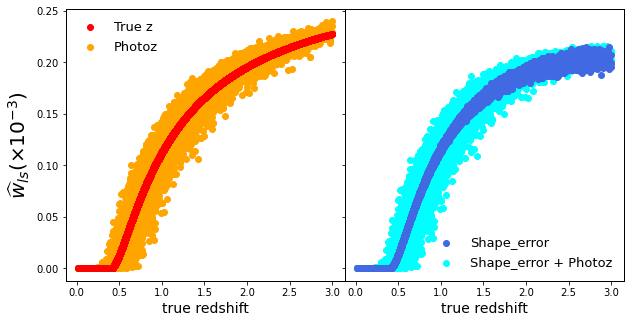

In [11]:
plt.rcParams['axes.linewidth'] = 1
fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = True)
fig.subplots_adjust(wspace=0, hspace=0)
ax[0].tick_params(axis='both', which = 'major', labelsize= 10)
ax[1].tick_params(axis='both', which = 'major', labelsize= 10)
ax[0].scatter(z_gal, 1e3*cl.galcat['w_ls_true']/np.sum(cl.galcat['w_ls_true']), c='r', label = 'True z', zorder = 100)
ax[0].scatter(z_gal, 1e3*cl.galcat['w_ls_photoz']/np.sum(cl.galcat['w_ls_photoz']), c='orange', label = 'Photoz')
ax[1].scatter(z_gal, 1e3*cl.galcat['w_ls_shape']/np.sum(cl.galcat['w_ls_shape']), c='royalblue', label = r'Shape_error', zorder = 100)
ax[1].scatter(z_gal, 1e3*cl.galcat['w_ls_photoz_shape']/np.sum(cl.galcat['w_ls_photoz_shape']), c='cyan', label ='Shape_error + Photoz')
ax[0].legend(frameon = False, fontsize = 13)
ax[1].legend(frameon = False, fontsize = 13)
ax[0].set_ylabel(r'$\widehat{w}_{ls} (\times 10^{-3})$', fontsize = 20)
ax[0].set_xlabel('true redshift', fontsize = 14)
ax[1].set_xlabel('true redshift', fontsize = 14)

The figure above shows the normalized weight per galaxy $\widehat{w}_{ls} = \frac{w_{ls}}{\sum _{s = 1}^N w_{ls}}$.
- The galaxy weights increase with the true galaxy redshift (left panel, red dots), i.e. galaxies far from the cluster are more sheared than closer ones.
- Using true redshift (left panel, red dots), weights for foreground galaxies are 0.
- Adding photoz's (left panel, orange dots):
   - weights are scattered around the true redshift weigthts (when photoz's are not biased)
   - foreground galaxies (with true redshift < $z_l$) have non-zero weights
- Adding shape error with redshift dependency $\sigma(z) = \sigma_0(1 + \alpha z)$ (right panel, blus dots), high redshift galaxies with measured shapes have smaller weights than considering true shapes (comparing to left panel, red dots).
- when combining photoz + shape error, both effects can be seen on galaxy weights (right panel, cyan dots).

### Background probability

In [12]:
noisy_data_z_2 = mock.generate_galaxy_catalog(1e14, cluster_z, 4, 
                                                cosmo, 
                                                zsrc = 'chang13', 
                                                #Delta_SO=200, 
                                                massdef='critical',
                                                halo_profile_model='nfw', 
                                                zsrc_min=0.,
                                                zsrc_max=3., 
                                                field_size=10., 
                                                shapenoise=0.5, 
                                                photoz_sigma_unscaled=0.03, 
                                                mean_e_err=.1,
                                                ngals=10000)
z_gal_2 = noisy_data_z_2['ztrue']
z_gal_photoz_2 = noisy_data_z_2['pzbins']
photoz_pdf_gal_2 = noisy_data_z_2['pzpdf']
#add redshift dependency on shape measurement error
noisy_data_z_2['e_err'] = noisy_data_z_2['e_err']*(1 + 0.4*noisy_data_z_2['z'])
cl_2 = clmm.GalaxyCluster('mock_cluster', 0, 0, cluster_z, noisy_data_z_2)

The probability for a galaxy with photometric redshift of being in the background of the cluster is given by
$$
P(z > z_l) = \int_{z_l}^{+\infty} dz\ p(z) 
$$

In [13]:
w_ls_photoz = cl_2.compute_galaxy_weights(z_source='ztrue', pzpdf='pzpdf', pzbins='pzbins', 
                        shape_component1 = 'e1', shape_component2 = 'e2', 
                        shape_component1_err = 'e_err', shape_component2_err = 'e_err', 
                        use_photoz = True, use_shape_noise = False, use_shape_error = False, 
                        weight_name = 'w_ls_photoz', p_background_name = 'p_background_photoz',
                        cosmo = cosmo,
                        is_deltasigma = True, add = True)

(re)computing p_background_photoz


Text(0.5, 0, 'true redshift')

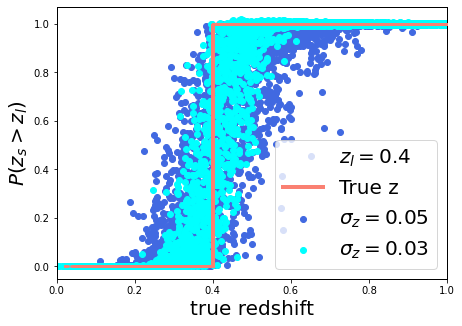

In [14]:
plt.rcParams['axes.linewidth'] = 1
plt.figure( figsize = (7,5))
plt.tick_params(axis='both', which = 'major', labelsize= 10)
plt.plot([],[],' ', label = f'$z_l = {cluster_z}$', )
plt.scatter(z_gal, cl.galcat['p_background_photoz'], c='royalblue', label = r'$\sigma_z = 0.05$')
plt.scatter(z_gal_2, cl_2.galcat['p_background_photoz'], c='cyan', label = r'$\sigma_z = 0.03$')
plt.vlines(cluster_z, 0,1,color='salmon', linewidth = 4, zorder = 100)
plt.scatter(z_gal, cl.galcat['p_background_true'], c='salmon', s = 3, zorder = 110)
plt.plot([],[], label = 'True z', linewidth = 4, c = 'salmon')
plt.xlim(0., 1)
plt.legend(frameon = True, fontsize = 20)
plt.ylabel(r'$P(z_s > z_l)$', fontsize = 20)
plt.xlabel('true redshift', fontsize = 20)

The figure above shows the background probability $P(z > z_l)$ for each galaxy.
- When using true redshift, the background probability is a Heavyside functiuon centered on $z_l$ (orange curve). 
- when using photometric redshift (cyan and blue dots), galaxies on the foreground of the cluster have non-zero probability to be in the background. Idem, for close galaxies in the background, the probability in being int the foreground is non-zero.

Selection of background galaxies can be made by considering cut $P(z > z_l) > P_{\rm threshold}$